In [1]:
from qiskit import *
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import DensityMatrix
from qiskit_ibm_runtime import QiskitRuntimeService
import numpy as np

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='7414c64492ea659aef108a78f4dc6d38737fe1d08c3d2a087333f2e500de6f50a3cb56957129c8b79c385917240c5b580019310d2ae0e9502eba0d774330b3ed'
)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


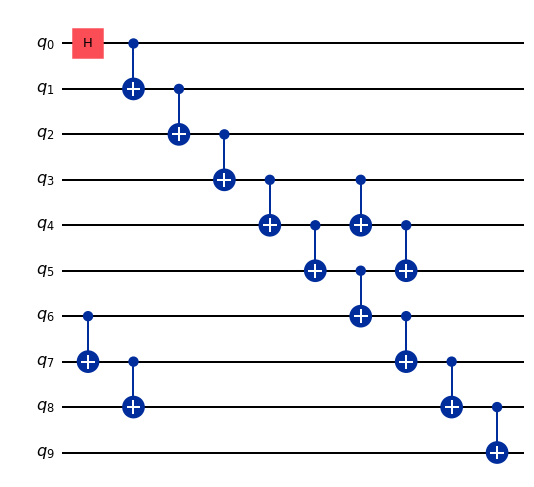

In [2]:
n_qubits = 10
n_partition = 4
qc = QuantumCircuit(n_qubits)

# Aplicar una puerta Hadamard al primer qubit para ponerlo en superposición
qc.h(0)

# Entrelazar los qubits utilizando puertas CNOT de manera secuencial
qc.cx(6,7)
qc.cx(7, 8)
for i in range(9):
    qc.cx(i, i+1)

qc.cx(3, 4)
qc.cx(4, 5)


display(qc.draw(output='mpl'))

# Simular el estado final

simulator = Aer.get_backend('statevector_simulator')
circ = transpile(qc, simulator)
job = simulator.run(circ)
result = job.result()

state = result.get_statevector()


In [3]:
# n_qubits = 15
# qc1 = QuantumCircuit(n_qubits)

# # Aplicar compuertas de un qubit
# for qubit in range(n_qubits):
#     qc1.h(qubit)  # Aplicar puerta Hadamard

# qc1.rx(0.5, 0)  # Puerta RX con ángulo 0.5 en el qubit 0
# qc1.ry(0.7, 1)  # Puerta RY con ángulo 0.7 en el qubit 1
# qc1.rz(1.2, 2)  # Puerta RZ con ángulo 1.2 en el qubit 2

# # Aplicar puertas de dos qubits
# for i in range(n_qubits - 1):
#     qc1.cx(i, i + 1)  # Puertas CNOT en qubits adyacentes
#     qc1.cz(i, i + 1)  # Puertas CZ en qubits adyacentes

# # Añadir algunas puertas adicionales
# qc1.swap(0, 5)  # Puerta SWAP entre qubits 0 y 5
# qc1.swap(10, 14)  # Puerta SWAP entre qubits 10 y 14

# qc1.u(1.5, 0, 0, 3)  # Puerta U en el qubit 3 (reemplaza U1)
# qc1.u(0.4, 1.2, 0, 4)  # Puerta U en el qubit 4 (reemplaza U2)
# qc1.u(0.3, 0.6, 1.0, 6)  # Puerta U en el qubit 6 (reemplaza U3)

# # Más puertas de dos qubits
# qc1.cx(7, 8)  # Puerta CNOT entre qubits 7 y 8
# qc1.cz(8, 9)  # Puerta CZ entre qubits 8 y 9
# qc1.swap(12, 13)  # Puerta SWAP entre qubits 12 y 13

# # Aplicar compuertas adicionales para mayor complejidad
# qc1.h(range(n_qubits))  # Aplicar puerta Hadamard a todos los qubits

# # Dibujar el circuito
# display(qc1.draw(output='mpl'))

# # Simular el estado final
# simulator = Aer.get_backend('statevector_simulator')
# circ = transpile(qc1, simulator)
# job = simulator.run(circ)
# result = job.result()

# state = result.get_statevector()
# print(state)

Matriz densidad reducida

In [4]:
from qiskit.quantum_info import partial_trace
from qiskit.quantum_info import entropy

# Definir los qubits a observar
def observed_qubits(n, n_qubits):
    if n >= n_qubits:
        raise ValueError("El número de qubits observados debe ser menor que el número total de qubits")
    observed_qubits = [i for i in range(n)]
    
    return observed_qubits


#  Calcular la traza parcial
reduced_density_matrix = partial_trace(state, [i for i in range(n_qubits) if i not in observed_qubits(n_partition, n_qubits)])

# Obtener los valores propios de la matriz de densidad
eigenvalues = np.linalg.eigvals(reduced_density_matrix.data)

rho = DensityMatrix(reduced_density_matrix).data

Entropia de Von Neumann

In [5]:

# Calcular la entropía de von Neumann
entropy_neumann = entropy(reduced_density_matrix)
if entropy_neumann < 10**-12:
    entropy_neumann = 0.0
print(f"La entropía de von Neumann es: {entropy_neumann}")

La entropía de von Neumann es: 1.0


Entropia de Hartley

In [6]:
# Calcular el rango (número de valores propios no nulos)
tolerance = 1e-10  # Para evitar problemas numéricos
rank = np.sum(eigenvalues > tolerance)
entropy_hertley = np.log2(rank)
print(f"La entropía de Hartley es: {entropy_hertley}")

La entropía de Hartley es: 1.0


Entropia de renyí

In [7]:
def S(n):  
    S = np.log2(np.trace(np.linalg.matrix_power(rho, n)))/(1-n)     
    if S < 10**-12:
        S = 0.0
    return S.real

N = 100

found_different_entropy = False

# Bucle para calcular las entropías
for i in range(2, N):
    entropy_i = S(i)
    if abs(entropy_i - entropy_neumann) > 10**-12:
        found_different_entropy = True
        print(f"La entropía de orden {i} es: {entropy_i}")

# Verificar si no se encontraron entropías diferentes
if not found_different_entropy:
    print("No se encontraron entropías diferentes a la de Neumann")

No se encontraron entropías diferentes a la de Neumann
